# `Extrinsic Calibration` mounted on robot arm

In [1]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import *
from util import *
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


##### parsing `UR5e`

In [2]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


### Camera view `following robot arm`

[0/7] obj_name:[obj_cylinder_1]
[1/7] obj_name:[obj_cylinder_2]
[2/7] obj_name:[obj_cylinder_3]
[3/7] obj_name:[obj_cylinder_1_thick]
[4/7] obj_name:[obj_cylinder_2_thick]
[5/7] obj_name:[obj_cylinder_3_thick]
[6/7] obj_name:[obj_box_1]


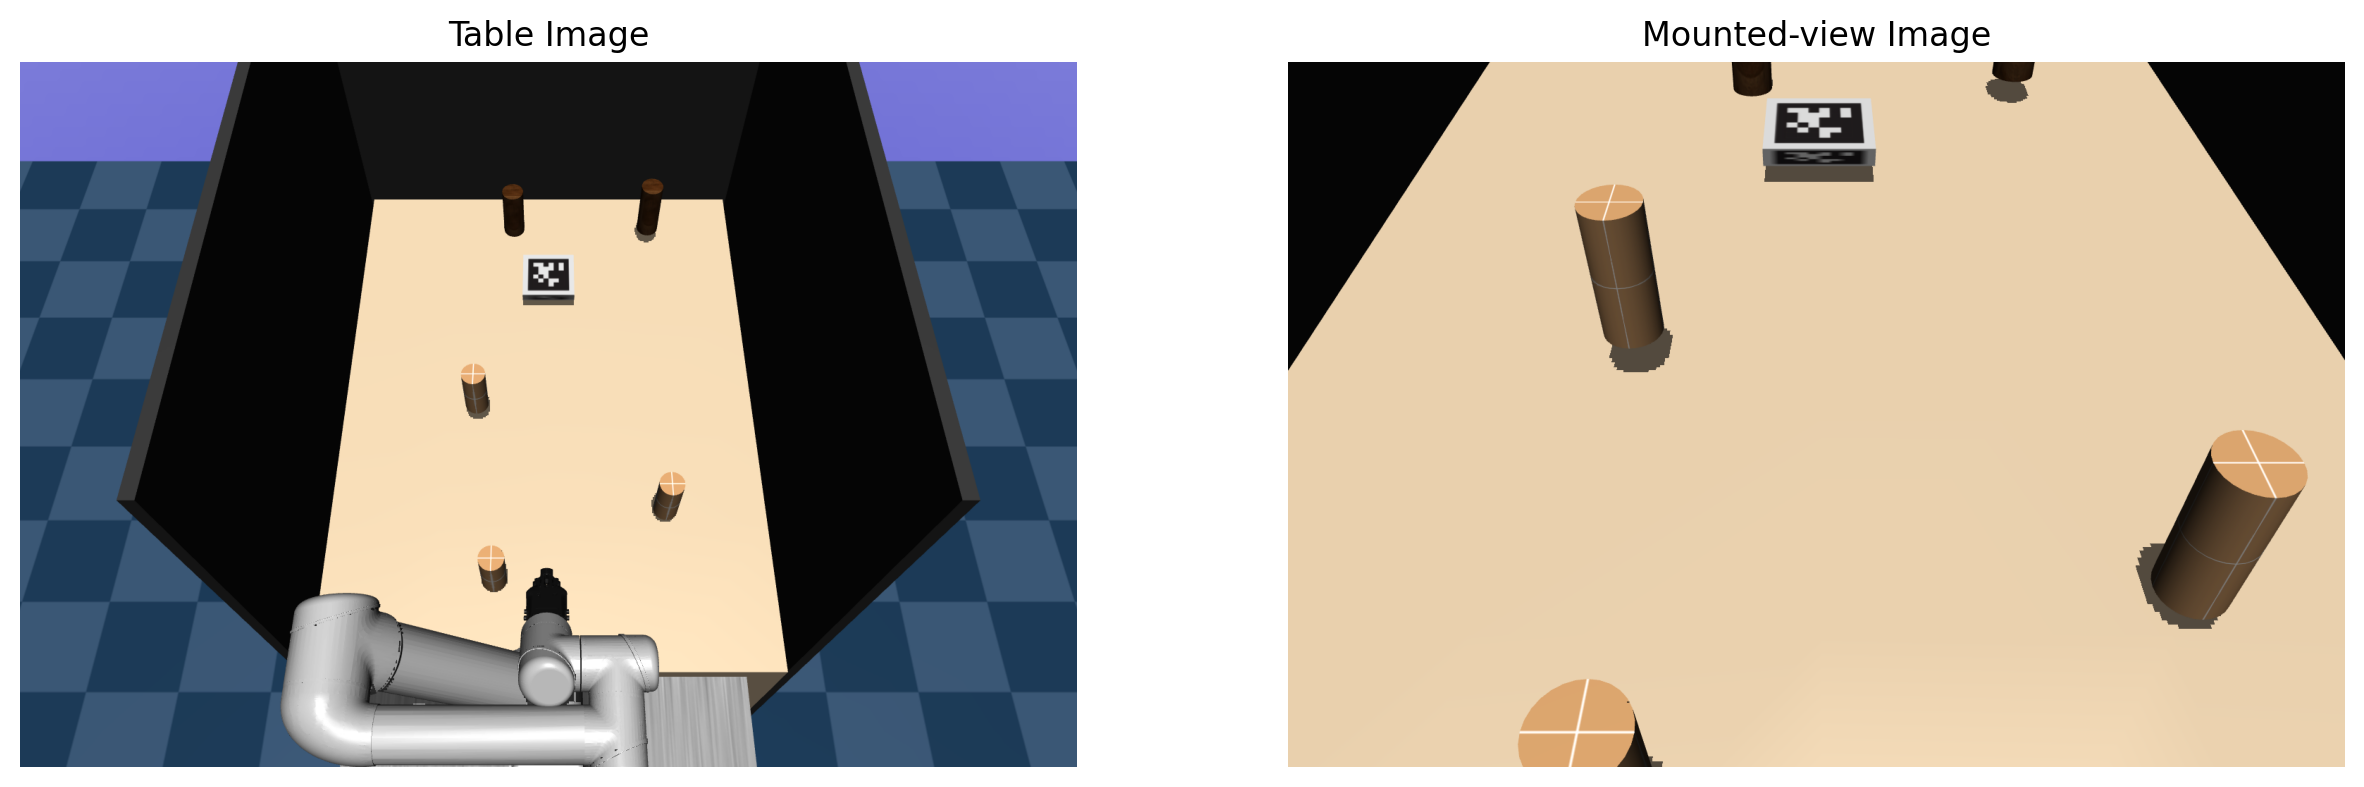

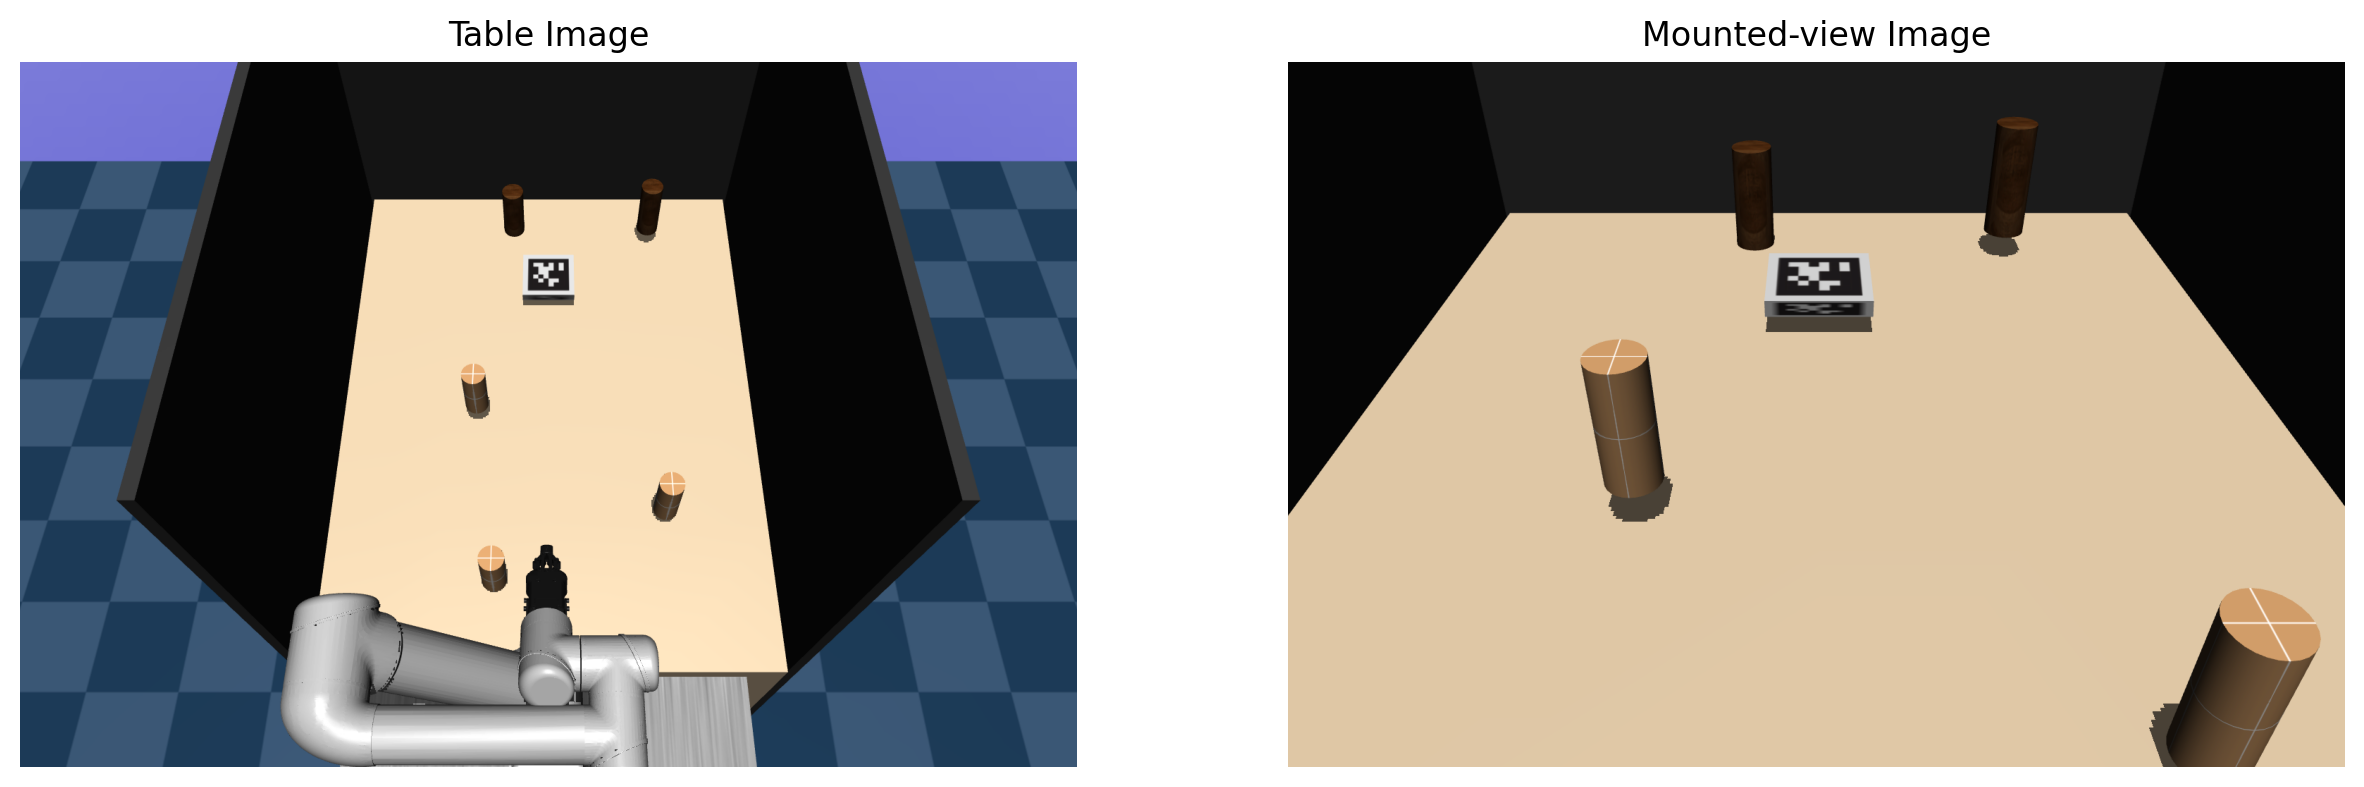

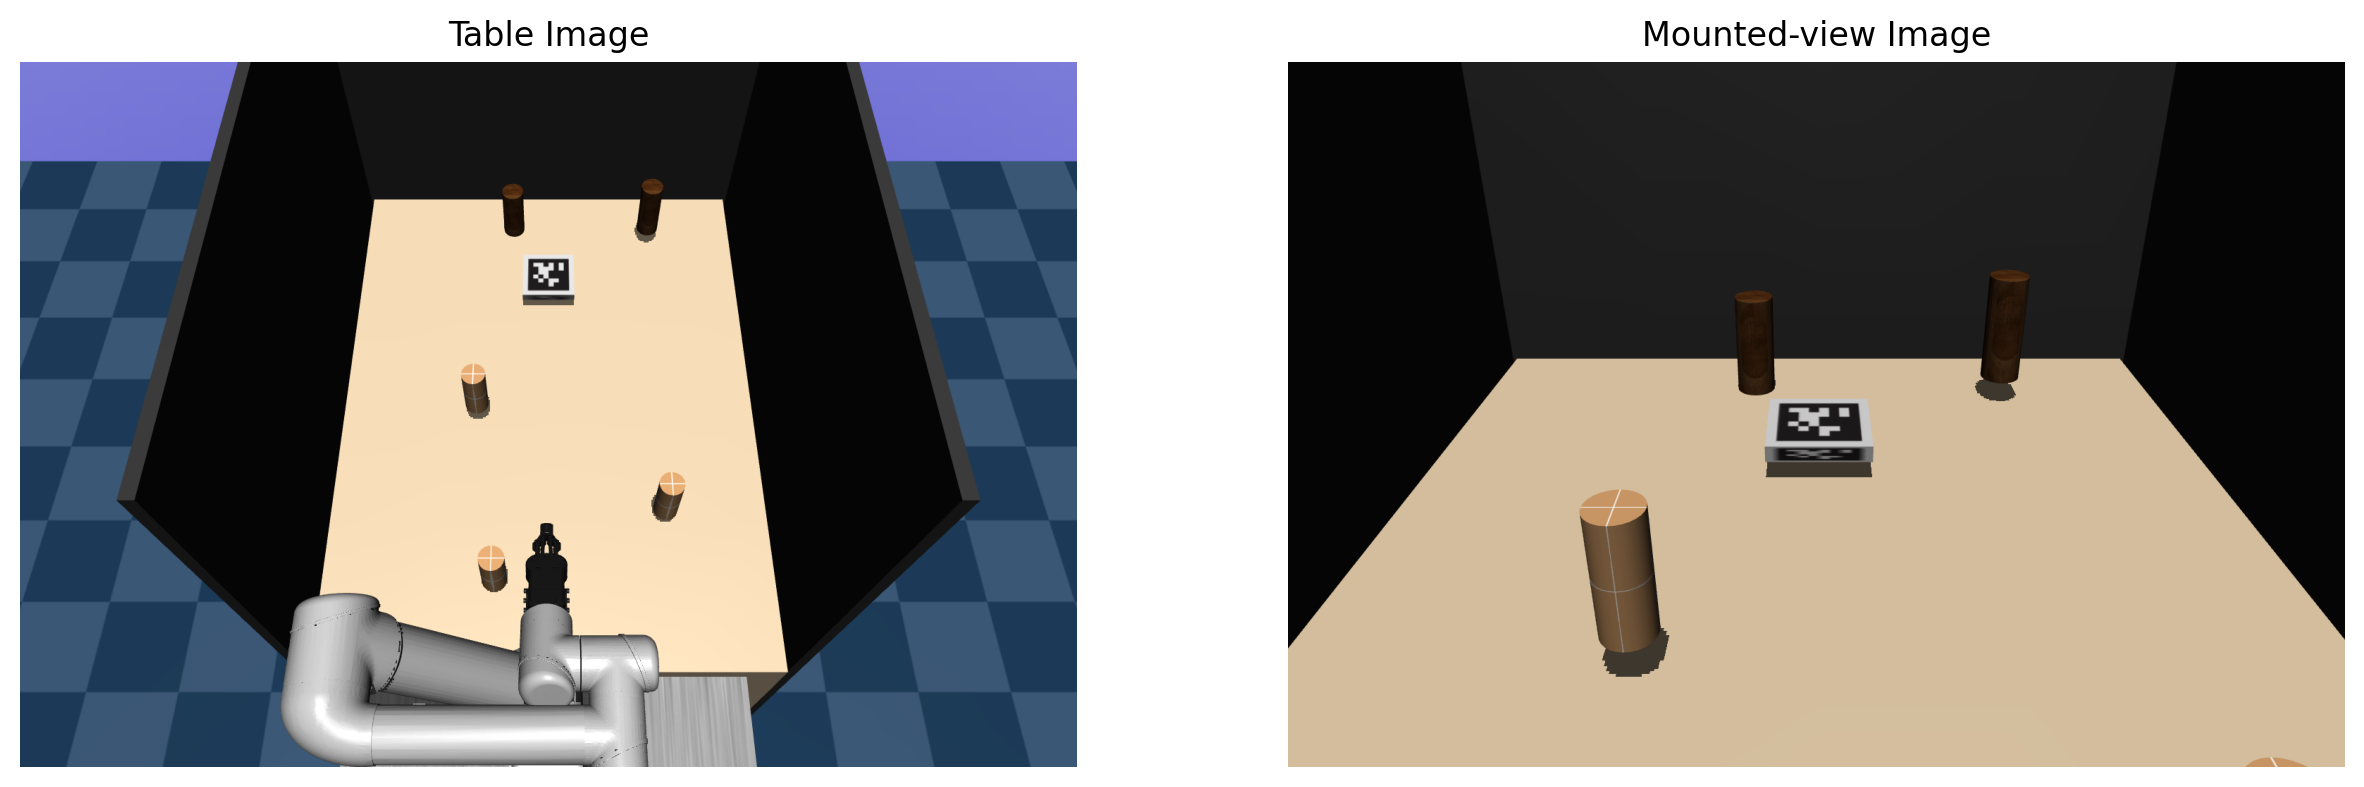

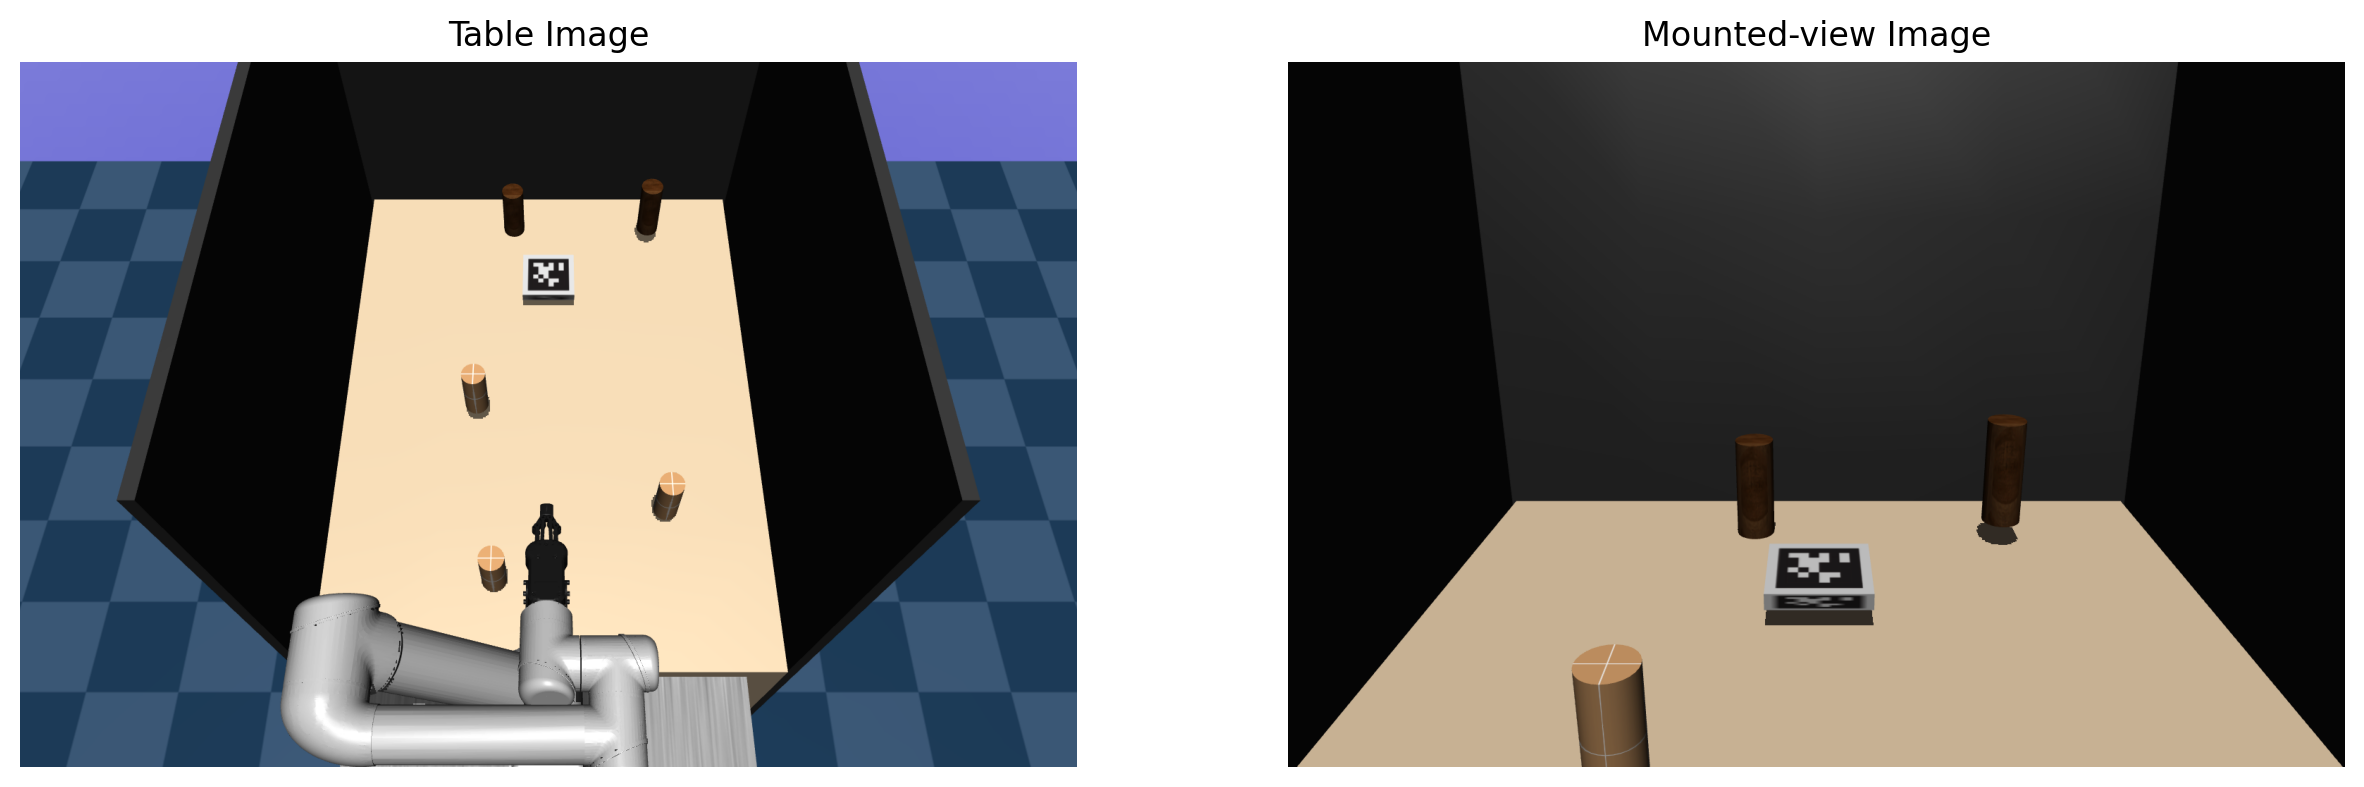

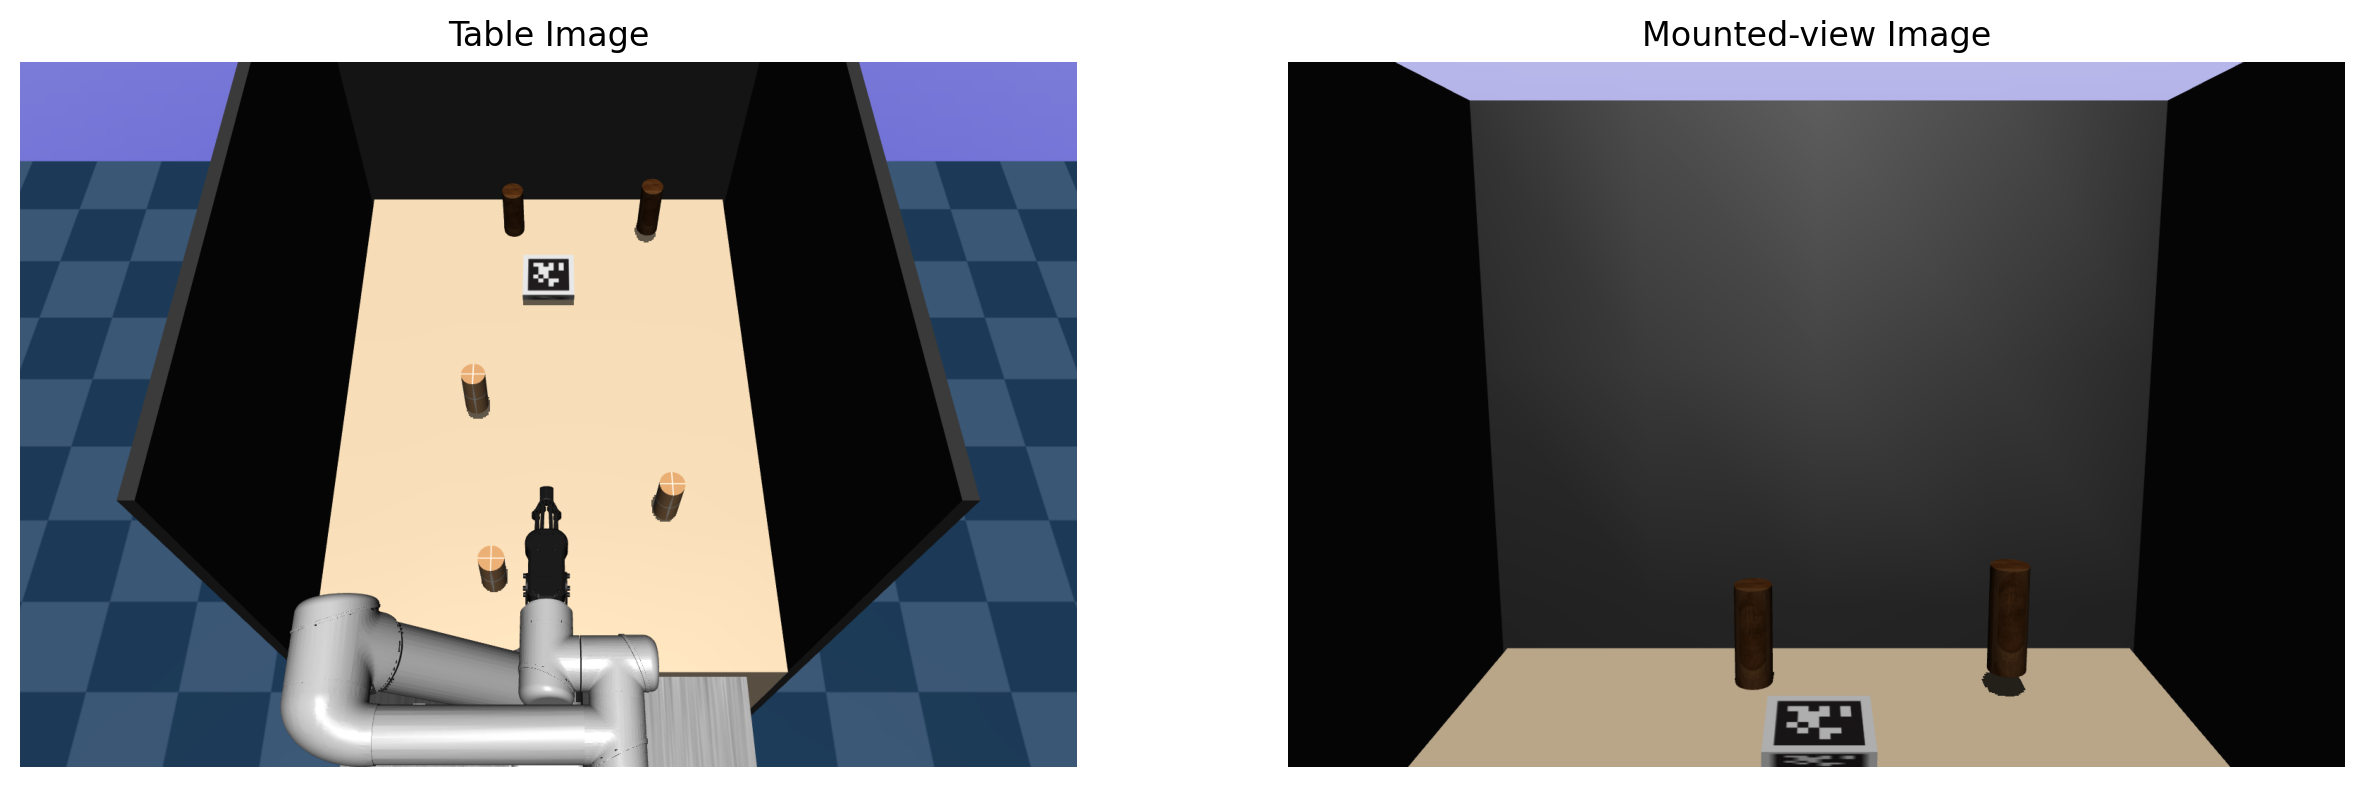

In [68]:
import math

# Check available objects whose names start with 'obj_'
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    print ("[%d/%d] obj_name:[%s]"%(obj_idx,len(obj_names),obj_name))

# Randomly initialize position of objects.
random_spawn_objects(env, prefix='obj_')

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

max_tick = 5
env.tick = 0

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4-0.05*env.tick*math.pi, -math.pi/2 ]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()

    # Get pose what I want to attach on.
    # Get wrist pose.
    p_eef = env.get_p_body("rg2_gripper_base_link")
    R_eef = env.get_R_body("rg2_gripper_base_link")
    R_eef_rpy = np.degrees(r2rpy(R_eef))

    wrist3_rot = env.get_R_body("ur_wrist_3_link")
    wrist3_pos = env.get_p_body("ur_wrist_3_link")
    wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))              # convert to 3x1 rpy matrix.

    # Arbitrary offset on camera btw arm.
    arbi_offset = [0.05, 0, 0.10]

    # Set camera information
    # View Up-right the table.
    # cam_table = env.set_cam_infos(cam_distance  = 0.0,
    #                     cam_azimuth   = 0,   # Z-axis: Yaw
    #                     cam_elevation = -90,      # X-axis: Roll                        
    #                     cam_lookat    = [0.75, 0, 3.5])  # arbitrary offset on camera.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")

    # Follow Robot wrist #3.
    cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                        cam_azimuth   = R_eef_rpy[2]+90,   # Z-axis: Yaw
                        cam_elevation = R_eef_rpy[0]+90,      # X-axis: Roll                        
                        cam_lookat    = p_eef+arbi_offset)  # arbitrary offset on camera.

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth_2_meters(img_depth))

    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

[0/7] obj_name:[obj_cylinder_1]
[1/7] obj_name:[obj_cylinder_2]
[2/7] obj_name:[obj_cylinder_3]
[3/7] obj_name:[obj_cylinder_1_thick]
[4/7] obj_name:[obj_cylinder_2_thick]
[5/7] obj_name:[obj_cylinder_3_thick]
[6/7] obj_name:[obj_box_1]


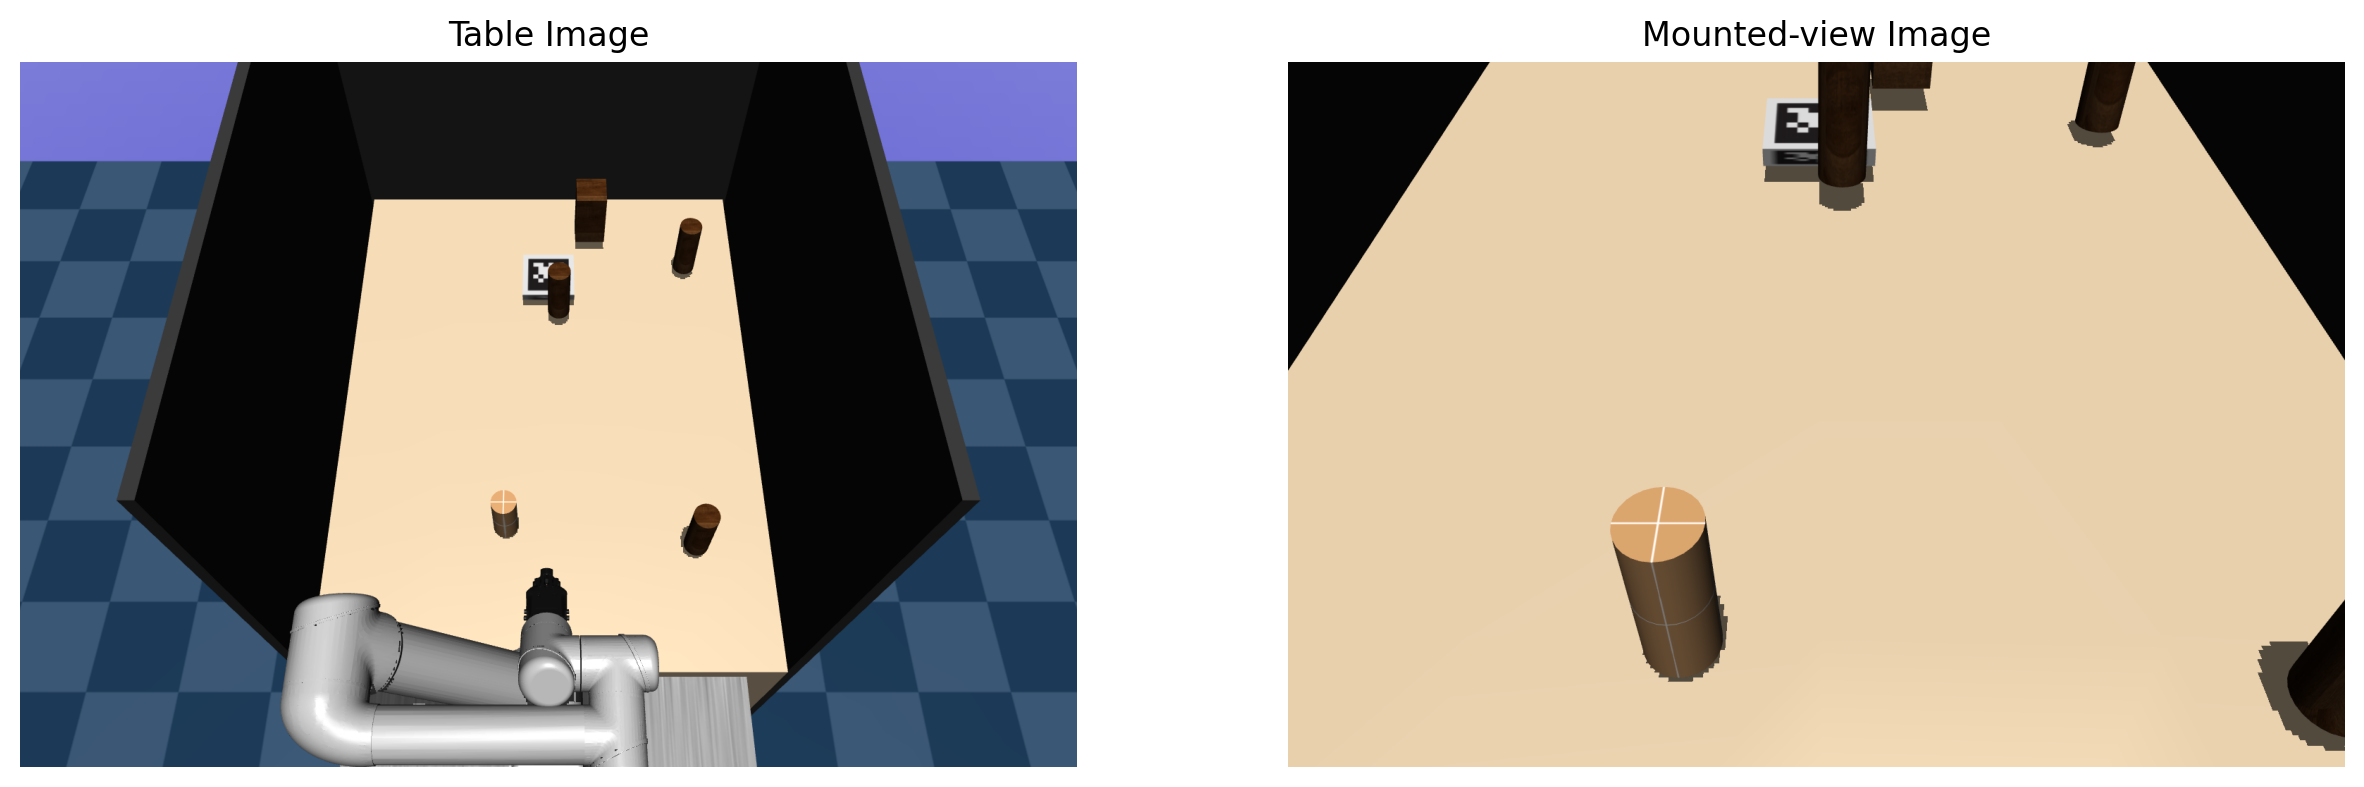

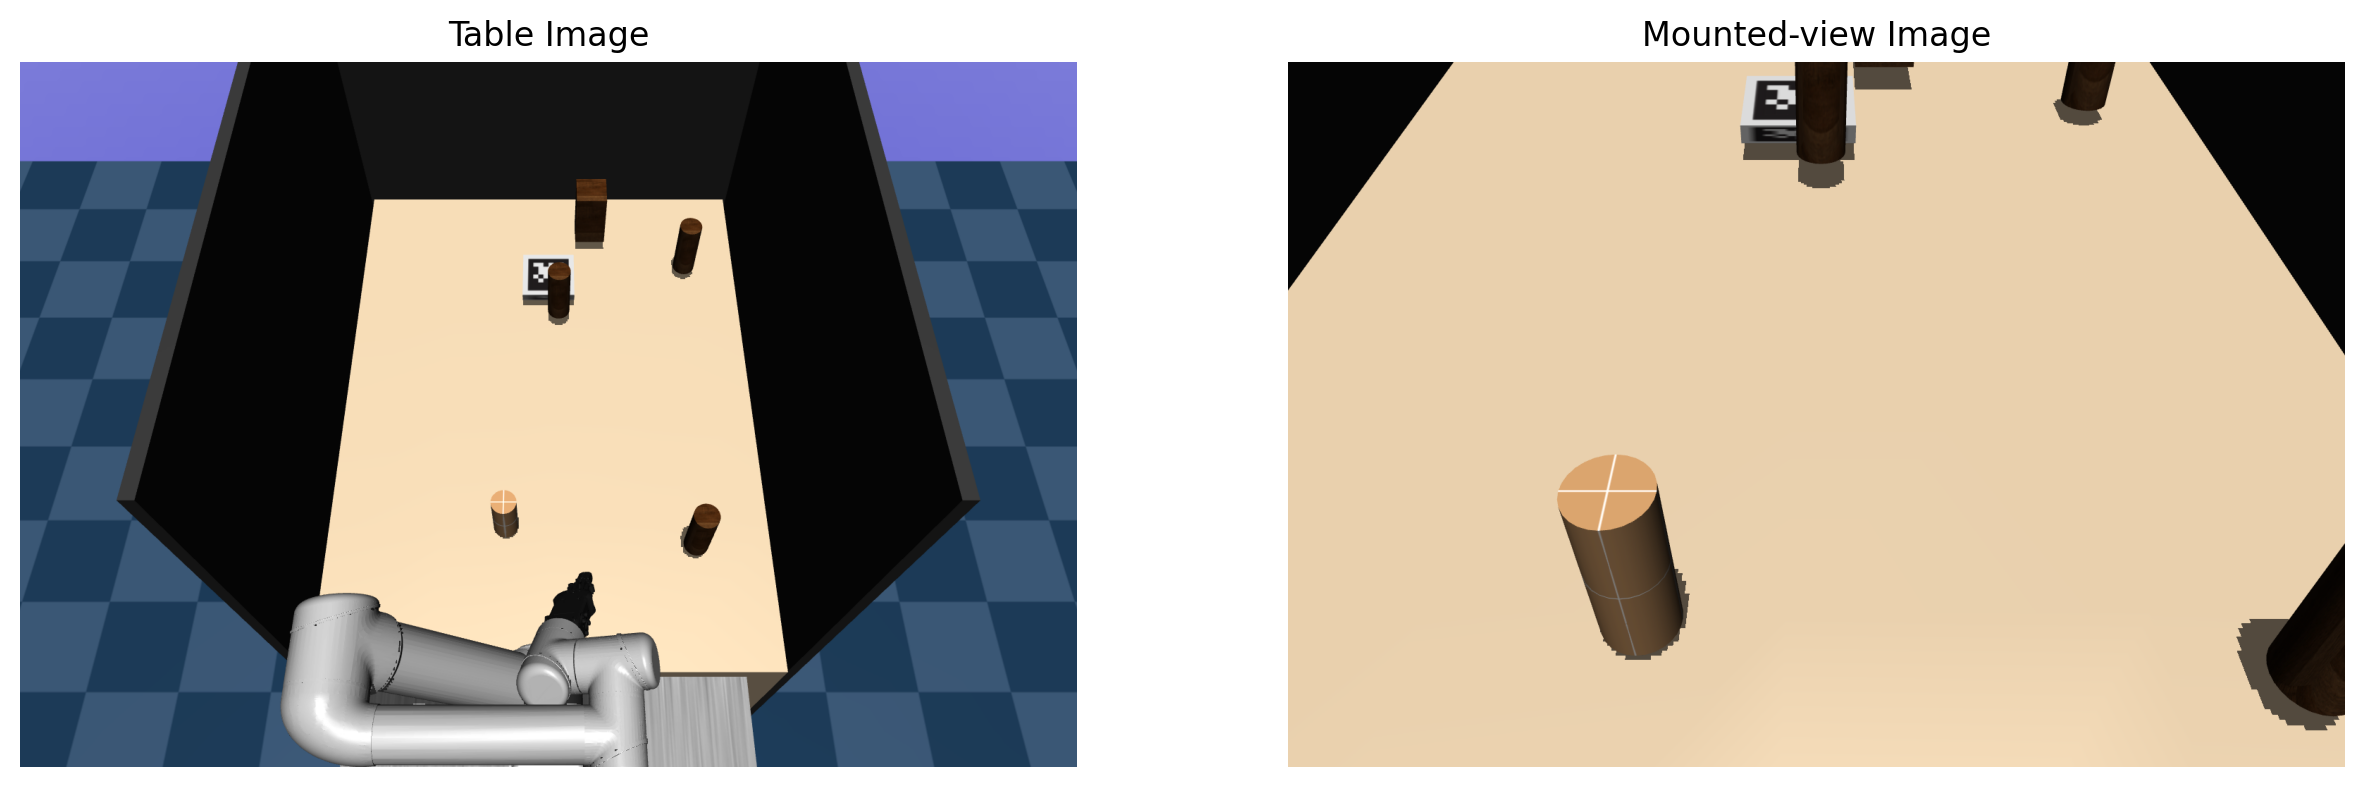

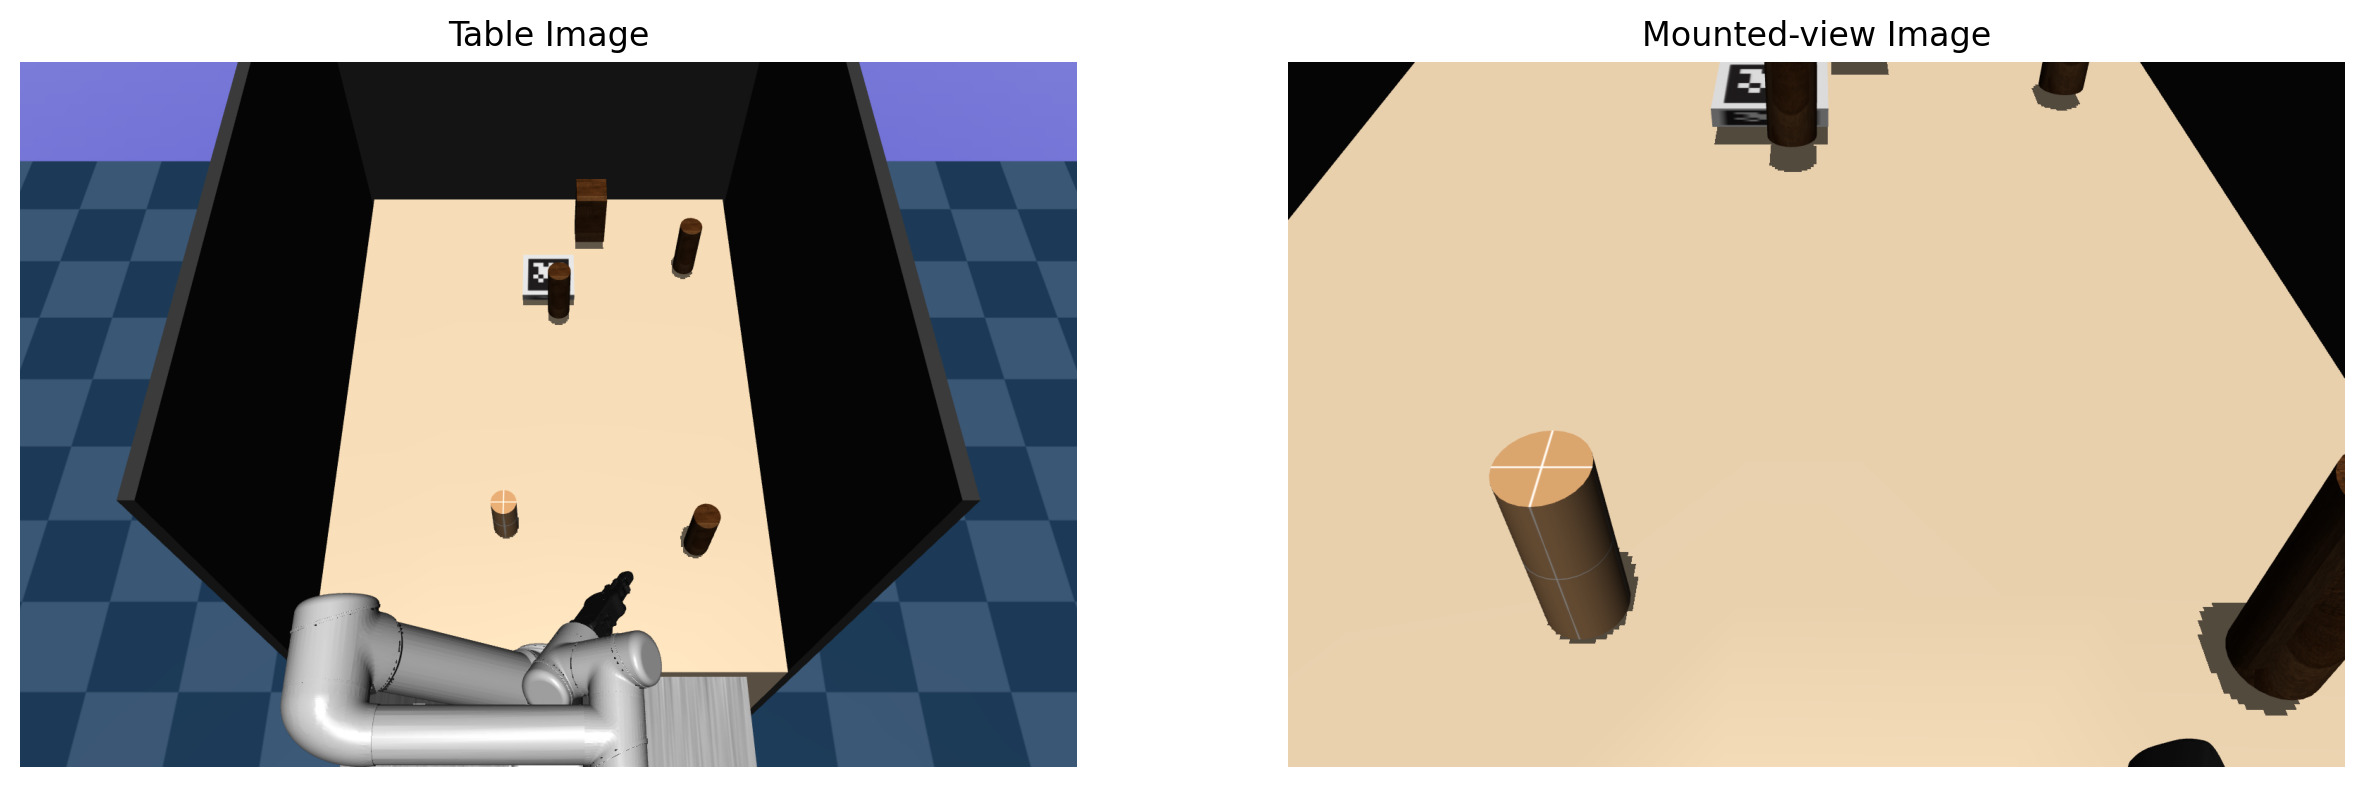

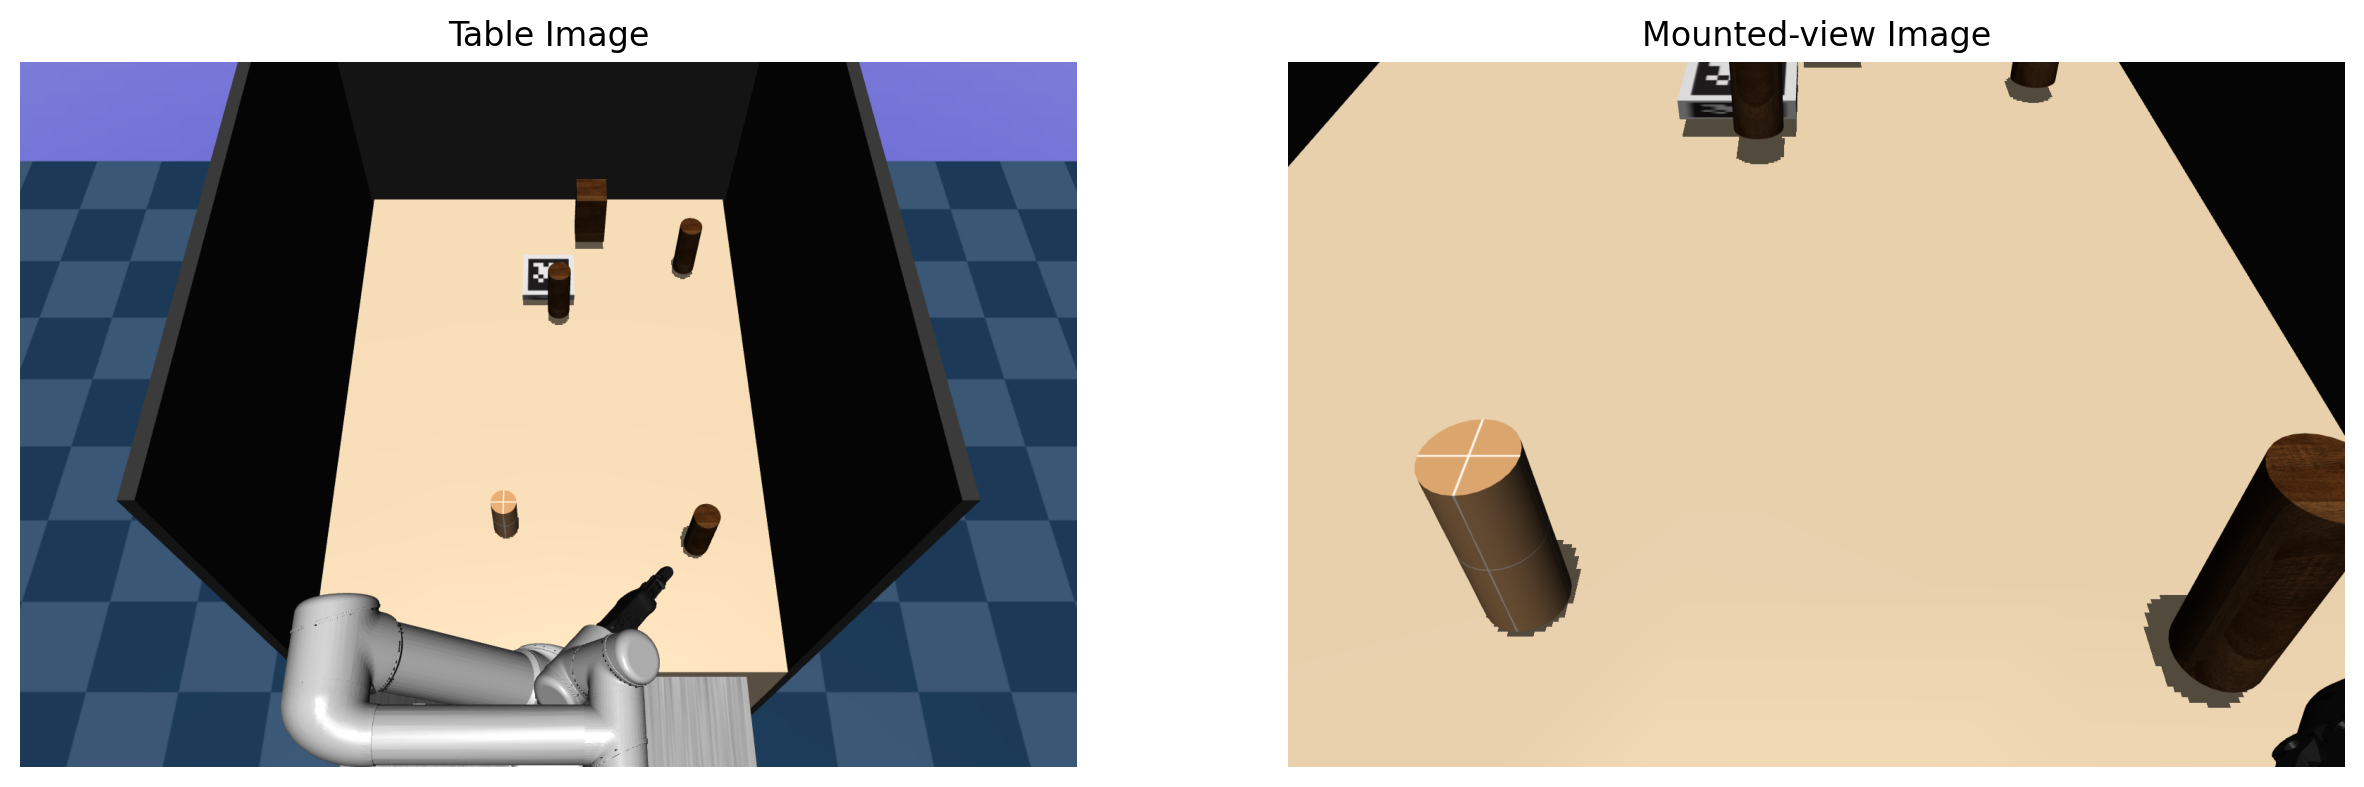

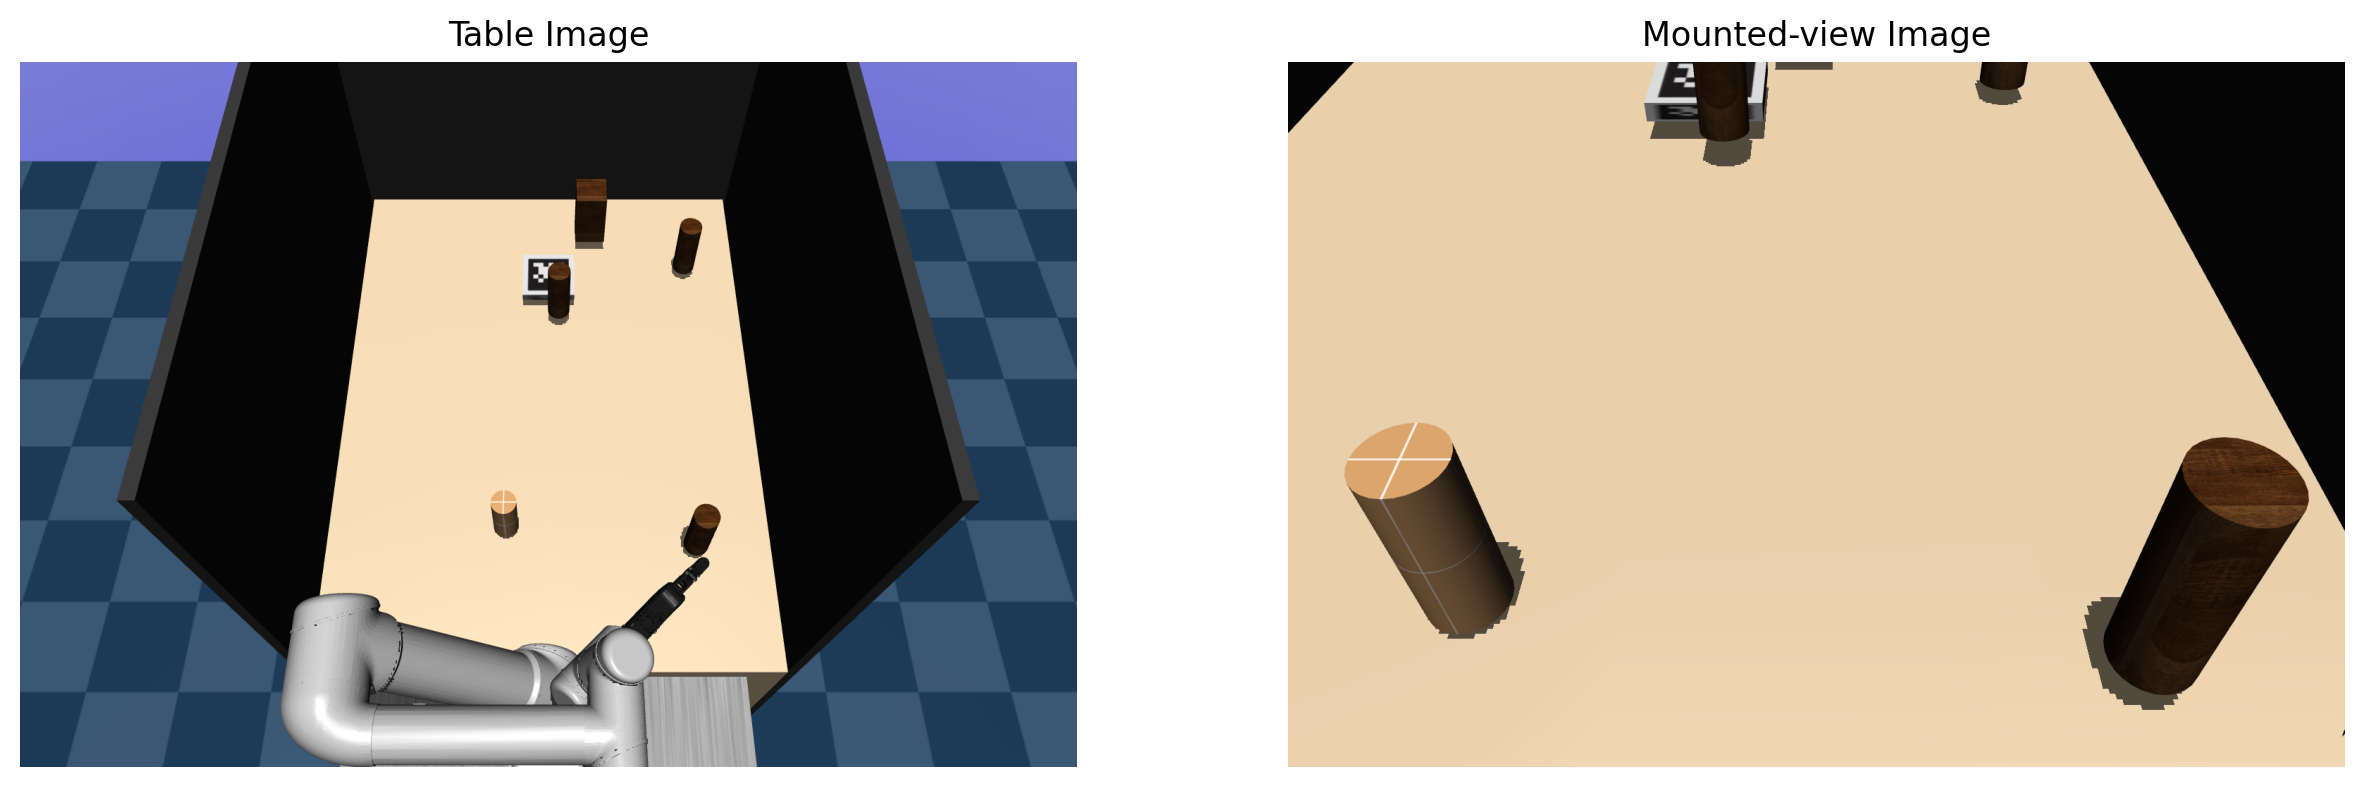

In [70]:
import math

# Check available objects whose names start with 'obj_'
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    print ("[%d/%d] obj_name:[%s]"%(obj_idx,len(obj_names),obj_name))

# Randomly initialize position of objects.
random_spawn_objects(env, prefix='obj_')

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

max_tick = 5
env.tick = 0

while env.tick < max_tick:
    # Set Joint Configurations
    init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2-0.1*env.tick*math.pi, math.pi/4, -math.pi/2 ]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # update object, robot configurations
    env.step()

    # Get pose what I want to attach on.
    # Get wrist pose.
    p_eef = env.get_p_body("rg2_gripper_base_link")
    R_eef = env.get_R_body("rg2_gripper_base_link")
    R_eef_rpy = np.degrees(r2rpy(R_eef))

    wrist3_rot = env.get_R_body("ur_wrist_3_link")
    wrist3_pos = env.get_p_body("ur_wrist_3_link")
    wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))              # convert to 3x1 rpy matrix.

    # Arbitrary offset on camera btw arm.
    arbi_offset = [0.05, 0, 0.10]

    # Set camera information
    # View Up-right the table.
    # cam_table = env.set_cam_infos(cam_distance  = 0.0,
    #                     cam_azimuth   = 0,   # Z-axis: Yaw
    #                     cam_elevation = -90,      # X-axis: Roll                        
    #                     cam_lookat    = [0.75, 0, 3.5])  # arbitrary offset on camera.
    cam_table = env.set_cam_infos(cam_distance  = 1.0,
                        cam_azimuth   = 0,   # Z-axis: Yaw
                        cam_elevation = -60,      # X-axis: Roll                        
                        cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")

    # Follow Robot wrist #3.
    cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                        cam_azimuth   = R_eef_rpy[2]+90,   # Z-axis: Yaw
                        cam_elevation = R_eef_rpy[0]+90,      # X-axis: Roll                        
                        cam_lookat    = p_eef+arbi_offset)  # arbitrary offset on camera.

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth_2_meters(img_depth))

    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("Mounted-view Image")
    plt.show()

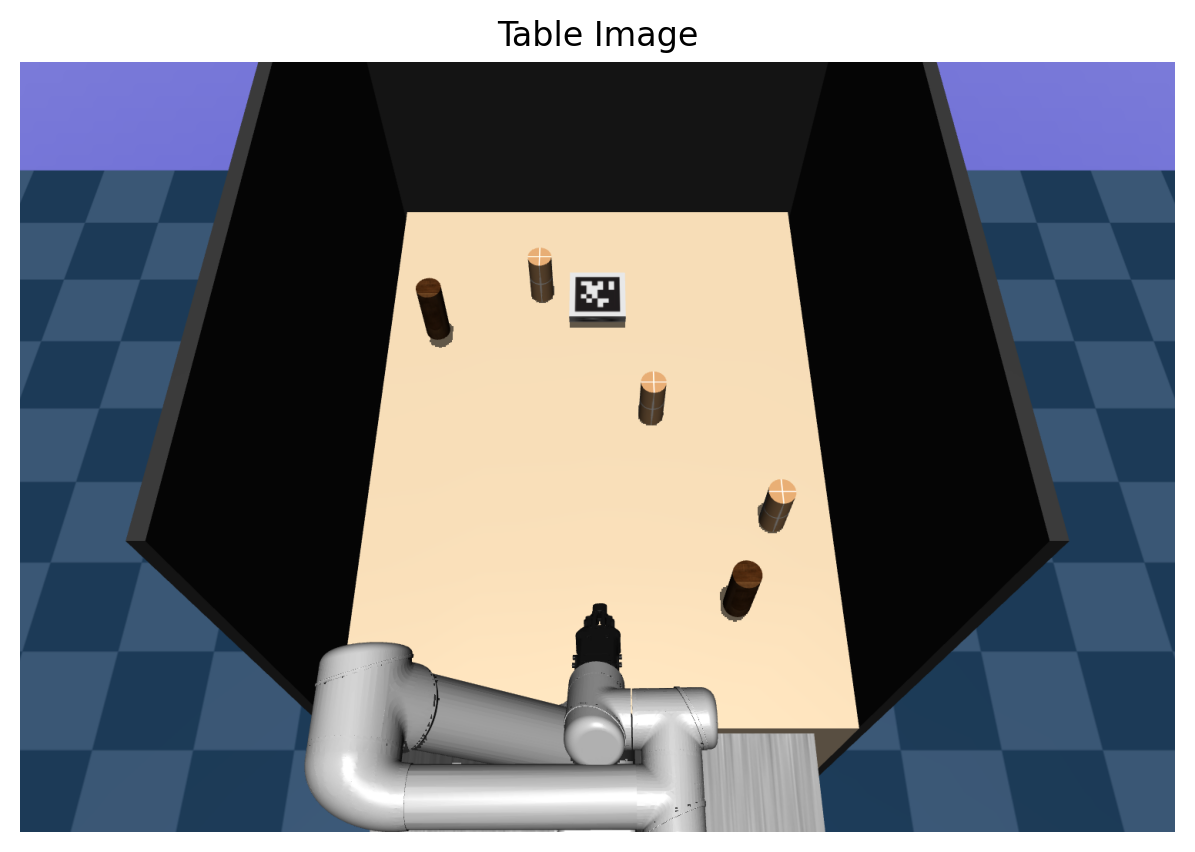

In [66]:
# Set camera information
# View Up-right the table.
cam_table = env.set_cam_infos(cam_distance  = 1.0,
                    cam_azimuth   = 0,   # Z-axis: Yaw
                    cam_elevation = -60,      # X-axis: Roll                        
                    cam_lookat    = [0.5, 0, 1.5])  # arbitrary offset on camera.

for _ in range(5):
    img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
plt.figure(figsize=(15,5))
plt.imshow(img_table); plt.axis('off')
plt.title("Table Image")
plt.show()

In [62]:
# Get pose what I want to attach on.
# Get wrist pose.
p_eef = env.get_p_body("rg2_gripper_base_link")
R_eef = env.get_R_body("rg2_gripper_base_link")
R_eef_rpy = np.degrees(r2rpy(R_eef))

wrist3_rot = env.sim.data.get_body_xmat("ur_wrist_3_link")  # represented in 3x3 R matrix
wrist3_pos = env.sim.data.get_body_xpos("rg2_gripper_base_link")
wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))              # convert to 3x1 rpy matrix.

In [52]:
r2rpy(wrist3_rot)

array([-2.34,  0.01,  1.57])

In [53]:
wrist3_rot_rpy

array([-134.22,    0.56,   90.01])

In [54]:
R_eef_rpy

array([-135.82,   -0.56,  -89.99])

In [49]:
# Set camera information
cam_infos = env.set_cam_infos(cam_distance  = 0.,
                    cam_azimuth   = wrist3_rot_rpy[2]+90,  # Z-axis: Yaw
                    cam_elevation = wrist3_rot_rpy[0],  # X-axis: Roll
                    cam_lookat    = wrist3_pos) 

cam_infos

{'cam_distance': 0.0,
 'cam_azimuth': 180.0,
 'cam_elevation': -135.0,
 'cam_lookat': array([0.34, 0.  , 1.12])}

##### get Rotational, Translational informations of wrist

In [55]:
wrist2_rot = env.sim.data.get_body_xmat("ur_wrist_2_link")
print(wrist2_rot)  # represented in R
wrist2_pos = env.sim.data.get_body_xpos("ur_wrist_2_link")
print(wrist2_pos)
wrist2_rot_rpy = np.degrees(r2rpy(wrist2_rot))
print(wrist2_rot_rpy)

wrist3_rot = env.sim.data.get_body_xmat("ur_wrist_3_link")
print(wrist3_rot)  # represented in R
wrist3_pos = env.sim.data.get_body_xpos("ur_wrist_3_link")
print(wrist3_pos)
wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))
print(wrist3_rot_rpy)

[[ 7.17e-01  6.97e-01 -1.51e-04]
 [ 6.98e-03 -6.96e-03  1.00e+00]
 [ 6.97e-01 -7.17e-01 -9.85e-03]]
[ 0.29 -0.09  1.18]
[-90.79 -44.22   0.56]
[[-1.41e-04  6.97e-01 -7.17e-01]
 [ 1.00e+00 -6.96e-03 -6.97e-03]
 [-9.85e-03 -7.17e-01 -6.97e-01]]
[0.29 0.   1.18]
[-134.22    0.56   90.01]


### Get 3D positions about 2D image

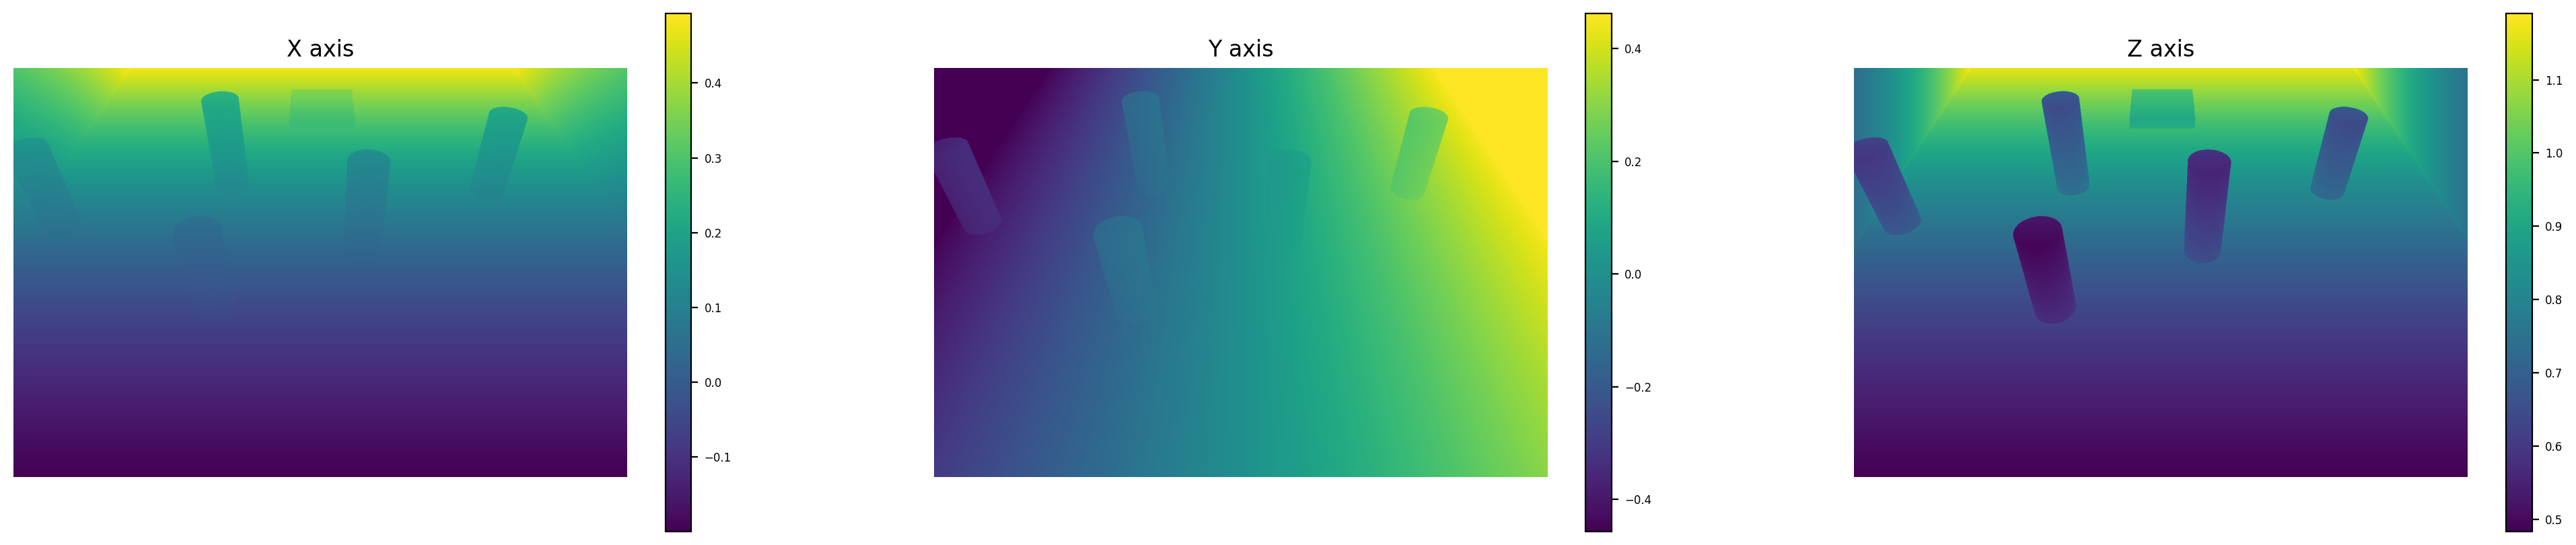

In [33]:
cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_width, height=env.render_height, camera_name="main1")

img_xyz = compute_xyz(img_real, cam_matrix=cam_matrix)

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.imshow(img_xyz[:,:,0]); plt.axis('off')
plt.title("X axis")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(img_xyz[:,:,1]); plt.axis('off')
plt.title("Y axis")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img_xyz[:,:,2]); plt.axis('off')
plt.title("Z axis")
plt.colorbar()
plt.show()

# Get `AX=XB` matrix data

## Get matrix `A`: Detected AprilTag pose

In [7]:
import apriltag

def get_apriltag_pose(env, img, img_depth):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about A that represents detected AprilTag pose in camera coordinate.
    """
    detector = apriltag.Detector()
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

    results = detector.detect(img_Gray)

    cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_width, height=env.render_height, camera_name="main1")

    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    cam_params = [fx, fy, cx, cy]

    img_real = np.array(env.depth_2_meters(img_depth))
    img_xyz = compute_xyz(img_real, cam_matrix=cam_matrix)

    # Render the detections on the image
    if len(results) > 0:
        draw_bbox(results, img, verbose=False)

        for r in results:
            pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)    # should check tag_size
            
            poseRotation = pose[:3, :3]
            poseTranslation = pose[:3, 3]
    
            center_point = [int(r.center[i]) for i in range(2)]    # in int type

            rot_april = pose[:3, :3]
            center_3d = np.array([img_xyz[center_point[1]][center_point[0]]])   # order of pixel array is y, x 

            T_april = np.concatenate((rot_april, center_3d.T), axis=1)  # 4x3 matrix
            T_april = np.concatenate((T_april, np.array([[0,0,0,1]])), axis=0)  # 4x4 matrix

        return T_april

    else:   # if any detected marker is none, return None.
        return None

get_apriltag_pose(env, img, img_depth)

array([[-1.00e+00,  1.67e-03,  6.58e-04, -3.26e-01],
       [-1.64e-03, -7.02e-01, -7.12e-01, -3.95e-03],
       [-7.27e-04, -7.12e-01,  7.02e-01,  9.54e-01],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])

## Get matrix `B`: Transformation operations about robot links

In [8]:
def get_env_body_names(env,prefix='ur_'):
    """
        Accumulate robot body names by assuming that the prefix is 'ur_'
    """
    body_names = [x for x in env.body_names if x[:len(prefix)]==prefix]

    return body_names
    
print(get_env_body_names(env))

def get_base2ee_matrix(env, link_prefix='ur_', verbose=False):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about B that represents sequenced transformation operations on [Robot base to Robot End-Effector].
    """
    # ur_links = ['ur_base_link', 'ur_shoulder_link', 'ur_upper_arm_link', 'ur_forearm_link', 'ur_wrist_1_link', 'ur_wrist_2_link', 'ur_wrist_3_link']

    link_names = get_env_body_names(env, link_prefix)
    T_links = []

    for idx, link in enumerate(link_names):
        if verbose == True:
            print(link)
        p_link = env.get_p_body(body_name=link)  # 3x3
        R_link = env.get_R_body(body_name=link)  # 3x1

        # T_link = pr2t(p_link, R_link)
        T_link = cv2.hconcat((R_link, p_link))      # 3x4
        T_link = np.vstack((T_link, np.array([0,0,0,1])))   # 4x4
        T_links.append(T_link)

    # start at 'ur_base_link'
    T_bs2end = T_links[0]
    for i in range(len(T_links)-1):
        T_bs2end = np.matmul(T_bs2end, T_links[i+1])

    return T_bs2end

bs2ee_matrix = get_base2ee_matrix(env, 'ur_')
print(bs2ee_matrix)

['ur_base_link', 'ur_shoulder_link', 'ur_upper_arm_link', 'ur_forearm_link', 'ur_wrist_1_link', 'ur_wrist_2_link', 'ur_wrist_3_link']
[[ 0.51  0.15  0.85 -0.76]
 [ 0.7   0.49 -0.51  1.05]
 [-0.49  0.86  0.15  3.52]
 [ 0.    0.    0.    1.  ]]


In [9]:
p_eef = env.get_p_body("rg2_gripper_base_link")
box_april_pos = env.sim.data.get_body_xpos("box_checker")

T_viewer, T_lookat = get_viewer_coordinate(cam_infos["cam_lookat"], cam_infos["cam_distance"], cam_infos["cam_elevation"], cam_infos["cam_azimuth"])

In [10]:
r2rpy(T_lookat)

array([-3.14e+00,  7.85e-01, -1.22e-16])

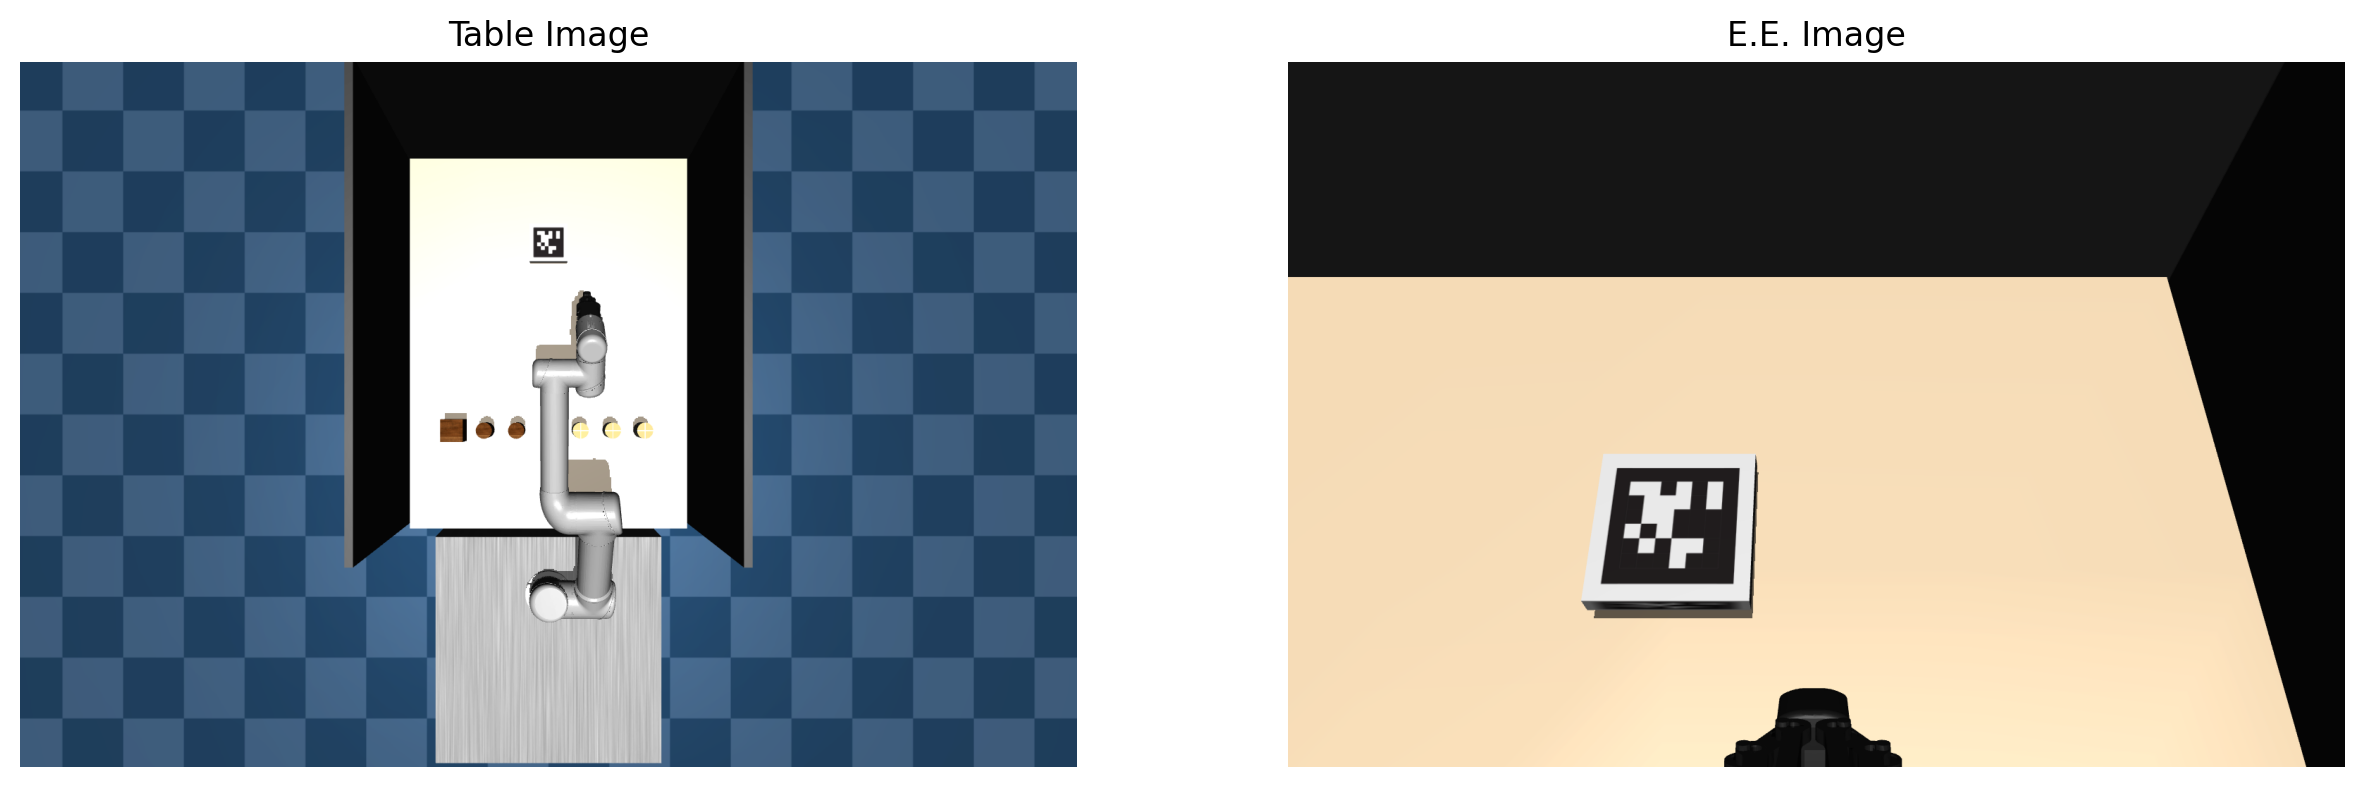

KeyboardInterrupt: 

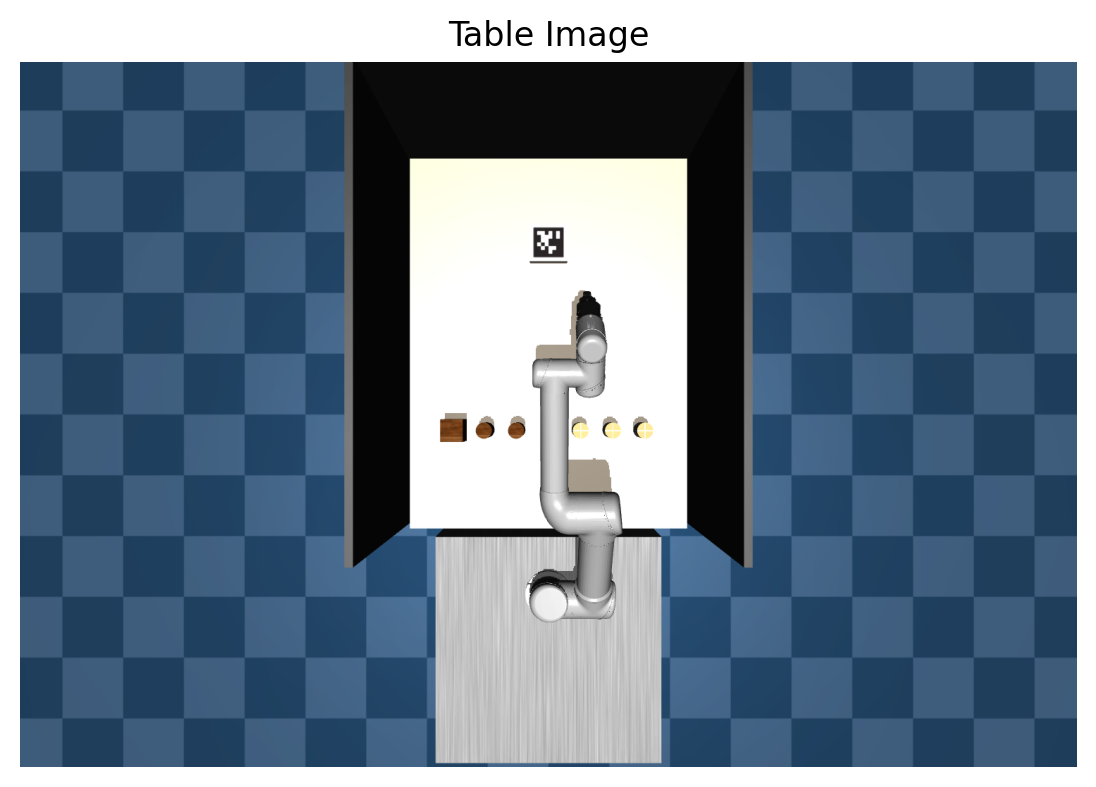

In [11]:
import apriltag

frames = []             # save frames as gif
poses = []              # apriltag pose list
bs2ee_matrix_list = []  # base to endeffector matrix list

# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects

for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

# update object, robot configurations
env.forward(INCREASE_TICK=False)

max_tick = 5
env.tick = 0

wrist3_rot = env.sim.data.get_body_xmat("ur_wrist_3_link")
wrist3_pos = env.sim.data.get_body_xpos("rg2_gripper_base_link")
wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))

# Follow Robot wrist #3.
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = wrist3_rot_rpy[2]+90,   # Z-axis: Yaw
                    cam_elevation = wrist3_rot_rpy[0],      # X-axis: Roll                        
                    cam_lookat    = p_eef+[0.05, 0, 0.10])  # arbitrary offset on camera.

# View Up-right the table.
cam_table = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0,   # Z-axis: Yaw
                    cam_elevation = -90,      # X-axis: Roll                        
                    cam_lookat    = [0.75, 0, 3.5])  # arbitrary offset on camera.

while env.tick < max_tick:

    # Set AprilTag configurations: rotate right direction.
    april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
    env.sim.data.qpos[april_addr_z] = -math.pi/2
   
    # Set Joint Configurations
    init_configurations = [-math.pi, -3*math.pi/4, -0.5, -1.3, math.pi/2, 0]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # Update all the configurations.
    env.step()

    # Get wrist pose.
    p_eef = env.get_p_body("rg2_gripper_base_link")
    R_eef = env.get_R_body("rg2_gripper_base_link")

    wrist3_rot = env.sim.data.get_body_xmat("ur_wrist_3_link")
    wrist3_pos = env.sim.data.get_body_xpos("rg2_gripper_base_link")
    wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))

    # Follow Robot wrist #3.
    cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                        cam_azimuth   = wrist3_rot_rpy[2]+90,   # Z-axis: Yaw
                        cam_elevation = wrist3_rot_rpy[0],      # X-axis: Roll                        
                        cam_lookat    = p_eef+[0.05, 0, 0.10])  # arbitrary offset on camera.

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(5):
        img_table = env.render_scene(mode='rgb_array', cam_infos=cam_table, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(img_table); plt.axis('off')
    plt.title("Table Image")
    # plt.show()

    for _ in range(5):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth_2_meters(img_depth))

    plt.subplot(1,2,2)
    plt.imshow(img); plt.axis('off')
    plt.title("E.E. Image")
    plt.show()
  
    pose = get_apriltag_pose(env, img, img_depth)
    
    # if there is any detected apriltag marker, then stroe the matrices.
    poses.append(pose)
    bs2ee_matrix = get_base2ee_matrix(env, 'ur_')
    bs2ee_matrix_list.append(bs2ee_matrix)

display_frames_as_gif(frames, "test-calibration-following-11.gif")

##### compare apriltag positions

In [ ]:
cam_lookat = cam_infos["cam_lookat"]
print(cam_lookat)

box_april_pos = env.sim.data.get_body_xpos("box_checker")
print(box_april_pos)

print(f"Ground-Truth AprilTag position: {cam_lookat - box_april_pos}")
print(f"Estimated AprilTag position: {poses[-1][:3,3]}")

[ 1.03 -0.11  1.37]
[1.3  0.   0.77]
Ground-Truth AprilTag position: [-0.27 -0.11  0.6 ]
Estimated AprilTag position: [-0.08 -0.11  0.65]


In [ ]:
# Get image
for rc_idx in range(len(env.sim.render_contexts)):
    print(rc_idx)
    env.sim.render_contexts[rc_idx].cam.lookat[0] = cam_lookat[0]
    env.sim.render_contexts[rc_idx].cam.lookat[1] = cam_lookat[1]
    env.sim.render_contexts[rc_idx].cam.lookat[2] = cam_lookat[2]
    env.sim.render_contexts[rc_idx].cam.distance  = cam_infos["cam_distance"]
    env.sim.render_contexts[rc_idx].cam.azimuth   = cam_infos["cam_azimuth"]
    env.sim.render_contexts[rc_idx].cam.elevation = cam_infos["cam_elevation"]


0


In [ ]:
print(dir(env.sim.render_contexts))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [ ]:
print(dir(env.sim.render_contexts[0].cam))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'azimuth', 'distance', 'elevation', 'fixedcamid', 'lookat', 'trackbodyid', 'type', 'uintptr']


In [ ]:
env.sim.render_contexts[0].cam.type

0